In [124]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [125]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Dense,
    Input,
    MaxPooling2D,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

In [126]:
np.random.seed(42)

In [127]:
ANOMALY_STR ="seven"
NORMAL_STR = "one"
USE_CASE ="digits"
img_path = os.path.join("imgs",USE_CASE)
if not os.path.isdir(img_path):
    os.mkdir(img_path)
ckpt_path = os.path.join("ckpts",USE_CASE)
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

# Preparing the data

In [128]:
def train_test_split(X, y, train_split=0.7, test_split=0.85):
    """Splits data in training and test data according to the defined boundaries."""
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * train_split), int(x_len * test_split)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)
    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [129]:
def merge_data(dataset, train_split=0.7, test_split=0.85):
    """merges training and test data set 
    :param dataset is assumed to be loaded from keras.datasets, thus the from 2-tuple(2-tuple) is assumed.
    :return value y is in one hot encoding
    """
    if not (len(dataset) == 2 and all([len(d) == 2 for d in dataset])):
        raise ValueError(
            "Datset has not the correct form. Please load from keras.datasets or convert to similar form."
        )

    (X_train, y_train), (X_test, y_test) = dataset

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) 
    y = np.concatenate((y_train, y_test))
    if len(X.shape) == 3: # MNIST data set
        X = X.reshape((list(X.shape) + [1]))
        
    
    # one-hot encode target columns
    y = to_categorical(y)

    return X,y

In [130]:
# CIFAR_10 = cifar10.load_data()
# CIFAR_100 = cifar100.load_data()
MNIST = mnist.load_data()
# FASHION_MNIST = fashion_mnist.load_data()

In [131]:
NORMAL = 1
ANOMALY = 7

In [132]:
X,y = merge_data(MNIST)
X = X / 255.0

In [133]:
def get_indices(filter):
    return np.where(np.argmax(y,axis=1)==filter)

In [134]:
normal_indices = get_indices(NORMAL)
X_normal, y_normal = X[normal_indices],y[normal_indices]
X_normal.shape,y_normal.shape

((7877, 28, 28, 1), (7877, 10))

In [135]:
anomaly_indices = get_indices(ANOMALY)
X_anomaly, y_anomaly = X[anomaly_indices],y[anomaly_indices]
X_anomaly.shape,y_anomaly.shape

((7293, 28, 28, 1), (7293, 10))

In [136]:
(X_normal_train, X_normal_test, X_normal_validate), (
    y_normal_train,
    y_normal_test,
    y_normal_validate,
) = train_test_split(X_normal, y_normal)
(X_anomaly_train, X_anomaly_test, X_anomaly_validate), (
    y_anomaly_train,
    y_anomaly_test,
    y_anomaly_validate,
) = train_test_split(X_anomaly, y_anomaly)

In [137]:
def plot_mnist(data):
    plt.imshow(data.reshape((28,28)))
    plt.gray()

In [138]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [139]:
def plot_samples(row_one, row_two, f_plot, outfile=""):
    """Plot 8 sample images of the row_one and row_two"""
    plt.figure(figsize=(16, 4))
    # row_one
    n = min([len(row_one),len(row_two),8])
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        hide_axis(ax)
        f_plot(row_one[i]) # row_one
        ax = plt.subplot(2, n, n+i+1)
        f_plot(row_two[i]) # row_two
        hide_axis(ax)
    if outfile!="":
        plt.savefig(outfile)

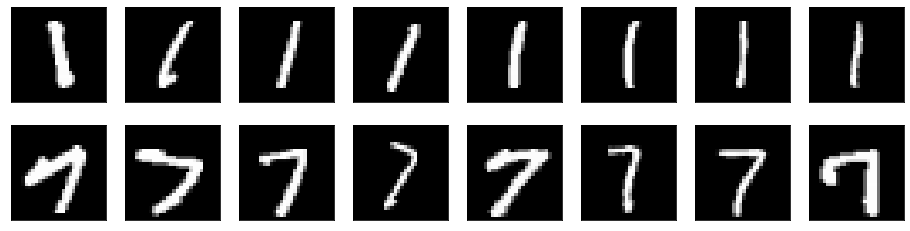

In [140]:
path = os.path.join(img_path,"{}-{}.png".format(NORMAL_STR,ANOMALY_STR))
plot_samples(X_normal_train, X_anomaly_train, plot_mnist,path)

# Extracting features with an auto encoder (ae)

In [141]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [142]:
def build_conv_ae(
    filters, input_shape=(28, 28, 1), kernel=(3, 3), pool_size=(2, 2), color="gray"
):
    # STRETCH GOAL: variable number of layers and pool_size
    pool_size = (2, 2)
    kernel = (3, 3)
    if len(filters) != 4:
        raise ValueError("Four Filters must be given. Sorry.")
    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # layer between input and middle layer
    i = 0
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(pool_size, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu")(decode)
    decode = UpSampling2D(pool_size)(decode)
    decoded = Conv2D(
        1 if color == "gray" else 3, kernel, activation="sigmoid", padding="same"
    )(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_ae(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder, encoder, decoder

## Training the feature extractor auto encoder

In [143]:
ckpt_loc = os.path.join(ckpt_path,"feature-extractor-ae.hdf5")

if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for %s feature extraction from directory %s..." % (USE_CASE,ckpt_loc))
    ae = load_model(ckpt_loc)
    encoder, decoder = get_codec_from_ae(ae)
    ae.summary()    
else:
    print("Training Autoencoder for %s feature extraction..." % USE_CASE)
    ae, encoder, decoder = build_conv_ae(filters=[16,12,8,2])
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    ae.summary()    
    ae.fit(
        X_normal_train,
        X_normal_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_normal_validate, X_normal_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )

Training Autoencoder for digits feature extraction...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 12)        1740      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 12)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 8)           872       
_________________________________________________________________
max_pooling2d_9 (MaxPo

Epoch 29/128
5513/5513 [==============================] - 1s 228us/step - loss: 0.0685 - val_loss: 0.0707

Epoch 00029: val_loss did not improve from 0.06934
Epoch 30/128
5513/5513 [==============================] - 1s 192us/step - loss: 0.0681 - val_loss: 0.0680

Epoch 00030: val_loss improved from 0.06934 to 0.06797, saving model to ckpts\digits\feature-extractor-ae.hdf5
Epoch 31/128
5513/5513 [==============================] - 1s 233us/step - loss: 0.0675 - val_loss: 0.0695

Epoch 00031: val_loss did not improve from 0.06797
Epoch 32/128
5513/5513 [==============================] - 1s 270us/step - loss: 0.0674 - val_loss: 0.0667

Epoch 00032: val_loss improved from 0.06797 to 0.06672, saving model to ckpts\digits\feature-extractor-ae.hdf5
Epoch 33/128
5513/5513 [==============================] - 1s 229us/step - loss: 0.0668 - val_loss: 0.0697

Epoch 00033: val_loss did not improve from 0.06672
Epoch 34/128
5513/5513 [==============================] - 1s 230us/step - loss: 0.0665 - v

5513/5513 [==============================] - 1s 266us/step - loss: 0.0610 - val_loss: 0.0613

Epoch 00071: val_loss improved from 0.06136 to 0.06133, saving model to ckpts\digits\feature-extractor-ae.hdf5
Epoch 72/128
5513/5513 [==============================] - 1s 248us/step - loss: 0.0609 - val_loss: 0.0612

Epoch 00072: val_loss improved from 0.06133 to 0.06119, saving model to ckpts\digits\feature-extractor-ae.hdf5
Epoch 73/128
5513/5513 [==============================] - 1s 216us/step - loss: 0.0609 - val_loss: 0.0612

Epoch 00073: val_loss improved from 0.06119 to 0.06116, saving model to ckpts\digits\feature-extractor-ae.hdf5
Epoch 74/128
5513/5513 [==============================] - 1s 256us/step - loss: 0.0608 - val_loss: 0.0611

Epoch 00074: val_loss improved from 0.06116 to 0.06109, saving model to ckpts\digits\feature-extractor-ae.hdf5
Epoch 75/128
5513/5513 [==============================] - 1s 255us/step - loss: 0.0607 - val_loss: 0.0611

Epoch 00075: val_loss improved fro

TODO fix parametrised ae building

## Evaluating the feature extractor

In [144]:
def evaluate_ae(ae, X_train, X_validate, X_test):
    eval_train = ae.evaluate(X_train, X_train)
    eval_validate = ae.evaluate(X_validate, X_validate)
    eval_test = ae.evaluate(X_test, X_test)
    return eval_train, eval_validate, eval_test

In [145]:
eval_train, eval_validate, eval_test = evaluate_ae(
    ae, X_normal_train, X_normal_validate, X_normal_test
)
print(eval_train, eval_test)

1182/1182 [==============================] - 0s 181us/step
0.05992409170319916 0.059252494835813234


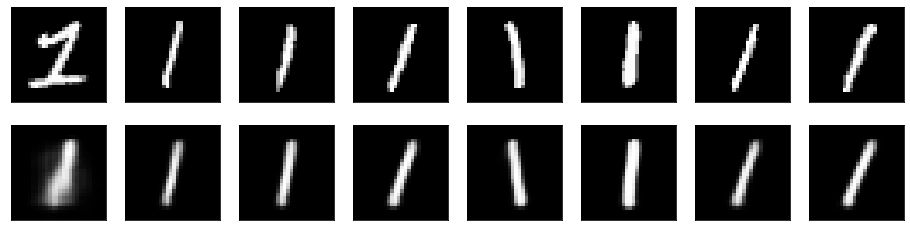

In [146]:
encoded_normal_imgs_train = encoder.predict(X_normal_train)  # used later for One Class Classification
encoded_normal_imgs_test = encoder.predict(X_normal_test) 
decoded_normal_imgs = decoder.predict(encoded_normal_imgs_test)
plot_samples(X_normal_test, decoded_normal_imgs, plot_mnist,os.path.join(img_path,"rec-{}.png".format(NORMAL_STR)))

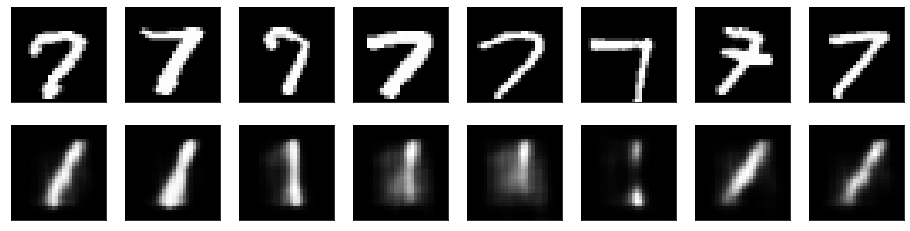

In [147]:
encoded_anomaly_imgs = encoder.predict(X_anomaly_test) # used later for One Class Classification
decoded_anomaly_imgs = decoder.predict(encoded_anomaly_imgs)
plot_samples(X_anomaly_test, decoded_anomaly_imgs, plot_mnist,os.path.join(img_path,"rec-{}.png".format(ANOMALY_STR)))

# Anomaly detection
## Loss based
### Computing the reconstruction loss for anomalies and normalities

In [148]:
def loss_per_img(img,rec_img):
    return np.sum(np.power(rec_img - img,2))

In [149]:
normal_losses = np.array([loss_per_img(i,ri) for i,ri in zip(X_normal_test,decoded_normal_imgs)])
anomaly_losses = np.array([loss_per_img(i, ri) for i, ri in zip(X_anomaly_test, decoded_anomaly_imgs)])

normal_losses.mean(), anomaly_losses.mean()

(5.78772041792575, 54.64229229951634)

In [150]:
def plot_hist(values, bins=50, relative=False, color="r"):
    t = np.linspace(values.min(), values.max(), bins)
    denominator = len(values) if relative else 1
    hist = np.histogram(values, bins)
    plt.plot(t, hist[0]/denominator, color)

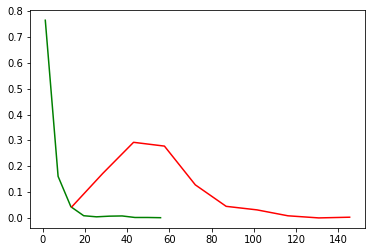

In [151]:
bins = 10
# loss distribution over the normal dataset
plot_hist(normal_losses,relative=True,color="g",bins=bins)
# loss distribution over the anomaly dataset 
plot_hist(anomaly_losses,relative=True,color="r",bins=bins)
plt.show()

### Evaluating the loss based approach

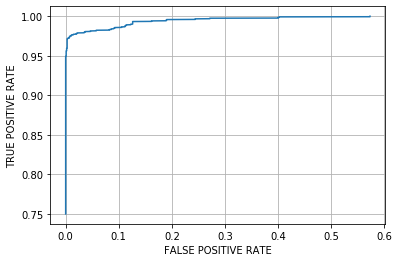

(0.9711999999999756, 18.61047104896136)

In [152]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 10000  # precision for getting the best threshold value
step_size = 1.0 / prec
TPs = np.arange(0.75, 1, step_size)

for i in TPs: 
    # loss value for detection of i*100 percent normal data points
    loss_boundary = np.sort(normal_losses)[int(len(normal_losses) * i)] 

    detected_normals = X_normal_test[normal_losses >= loss_boundary]
    undetected_anomalies = X_anomaly_test[anomaly_losses < loss_boundary]

    FP_rate = len(undetected_anomalies) / len(
        anomaly_losses
    )  # ratio between not detected loss values for anomalies
    FN_rate = len(detected_normals) / len(
        normal_losses
    )  # ratio between not detected loss values for anomalies

    FPs = np.append(FPs, FP_rate)  # not detected anomalies
    FNs = np.append(FNs, FN_rate)  # as anomalies detected normalities
    if FP_rate + FN_rate <= min(FNs + FPs): # less or equal since we want the biggest TP_rate (i)
        loss_threshold = i
        best_boundary = loss_boundary
        
    # print every 1/10 threshold step
    if (int(i * prec)) % prec // 10 == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, FN_rate + FP_rate)
        )
    # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)

plt.plot(FPs,TPs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold, best_boundary

In [153]:
detected_normals = X_normal_test[normal_losses >= best_boundary] # values on the boundary are seen as anomalies
undetected_anomalies = X_anomaly_test[anomaly_losses < best_boundary]
len(detected_normals), len(undetected_anomalies)

(35, 3)

In [ ]:
plot_samples(detected_normals,undetected_anomalies,plot_mnist, os.path.join(img_path,"wrong-{}.png".format(USE_CASE)))

### Predicting with the reconstruction loss approach

In [171]:
def is_anomaly(X,boundary):
    rec_img = ae.predict(X.reshape(1,28,28,1))
    return loss_per_img(rec_img,X) > boundary

In [172]:
this_should_be_false = is_anomaly(X_normal_validate[0], best_boundary)
this_should_be_true = is_anomaly(X_anomaly_validate[0], best_boundary)
this_should_be_false, this_should_be_true

(False, True)

## One Class SVM approach

In [155]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

In [204]:
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
            -1, np.prod(encoded_normal_imgs_train.shape[1:])
        )
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
            -1, np.prod(encoded_normal_imgs_test.shape[1:])
        )
encoded_anomaly_imgs = encoded_anomaly_imgs.reshape(-1, np.prod(encoded_anomaly_imgs.shape[1:]))
best_metrics =0
for i in np.arange(0.1, 1, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_normal_imgs_train)
    
    score_normal = clf.predict(encoded_normal_imgs_test)
    bins = 2
    # hist_normal = np.histogram(score_normal, bins)
    # t = np.linspace(score_normal.min(), score_normal.max(), bins)
    # plt.bar(t, hist_normal[0], width=0.5, color="g")
    # plt.show()

    score_anomaly = clf.predict(encoded_anomaly_imgs)

    # hist_anomaly = np.histogram(score_anomaly, bins)
    # t = np.linspace(score_anomaly.min(), score_anomaly.max(), bins)
    # plt.bar(t, hist_anomaly[0], width=0.5, color="r")
    # plt.show()


    TP = len(score_normal[score_normal == 1])
    FN = len(score_normal[score_normal == -1])

    TN = len(score_anomaly[score_anomaly == -1])
    FP = len(score_anomaly[score_anomaly == 1])
    accuracy = (TP + TN) / (len(score_normal) + len(score_anomaly))
    precision = TP / (TP + FN)
    recall = TP / (TP + FP)
    if (accuracy+precision+recall)/3 > best_metrics:
        best_nu = i
        best_metrics = (accuracy+precision+recall)/3
        oc_svm = clf
    print("%.2f" % i, accuracy, precision, recall)
best_nu,best_metrics


0.10 0.9103690685413005 0.8967851099830795 0.9281961471103327
0.20 0.8804920913884007 0.7961082910321489 0.9681069958847737
0.30 0.8347978910369068 0.6971235194585449 0.9786223277909739
0.40 0.7926186291739895 0.6099830795262268 0.9849726775956285
0.50 0.7451669595782073 0.511844331641286 0.9950657894736842
0.60 0.6884885764499121 0.4027072758037225 0.9937369519832986
0.70 0.6432337434094904 0.3147208121827411 0.9946524064171123
0.80 0.5900702987697716 0.21150592216582065 0.9960159362549801
0.90 0.5373462214411248 0.10998307952622674 0.9923664122137404


(0.1, 0.9117834418782375)

In [226]:
def is_anomaly_svm(X,oc_svm):
    X = X.reshape((1,X.shape[0]))
    prediction = oc_svm.predict(X)[0]
    return prediction == -1

In [228]:
this_should_be_false_svm = is_anomaly_svm(encoded_normal_imgs_train[0], oc_svm)
this_should_be_true_svm = is_anomaly_svm(encoded_anomaly_imgs[0], oc_svm)
this_should_be_false_svm, this_should_be_true_svm

(False, True)

# TODO: Encoded feature analysis with our friend CF Gauss

In [157]:
flat_shape = np.prod(encoded_normal_imgs_train.shape[1:], dtype=np.int64)
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
    len(encoded_normal_imgs_train), flat_shape
)
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
    len(encoded_normal_imgs_test), flat_shape
)

In [158]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [159]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [160]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [161]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [162]:
X= encoded_normal_imgs_test
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)


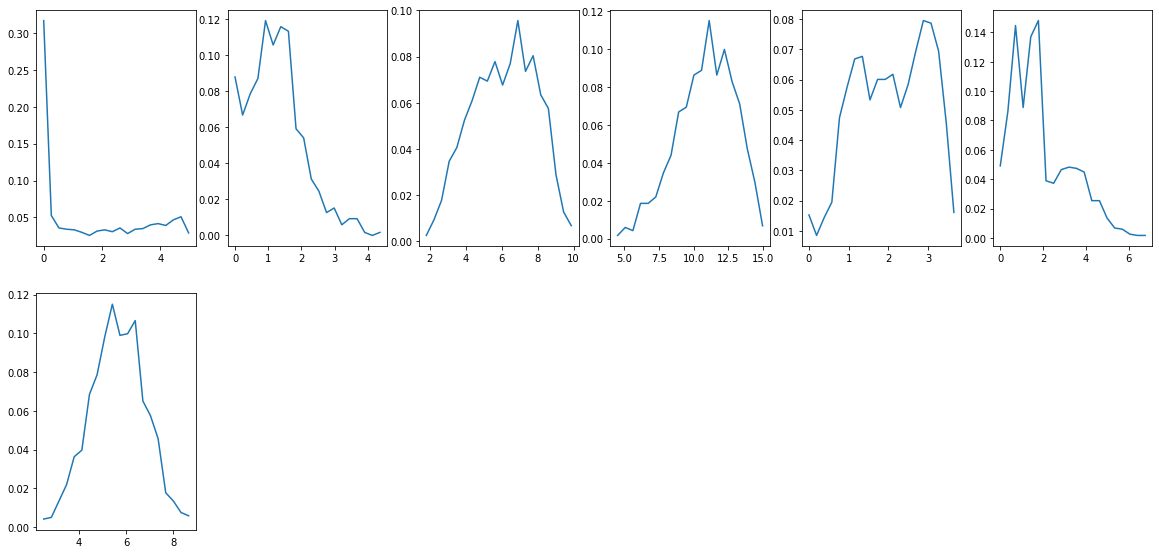

In [163]:
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))

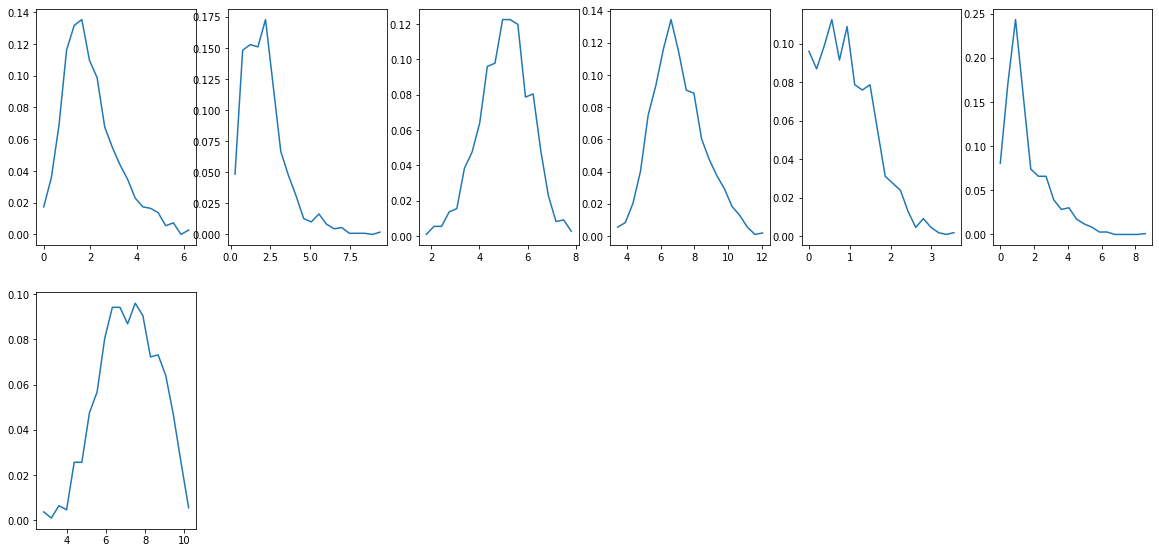

In [164]:
X= encoded_anomaly_imgs
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))